In [230]:
import ROOT
import math
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import json

from scipy.optimize import curve_fit

def double_sided_crystal_ball(x, N, mu, sigma, alpha_l, n_l, alpha_r, n_r):
    """
    Double-Sided Crystal Ball Function.
    
    Parameters:
      x      : Independent variable.
      N      : Normalization constant.
      mu     : Mean (peak position).
      sigma  : Standard deviation of the Gaussian core.
      alpha_l: Left side threshold (positive, defines when the low tail starts).
      n_l    : Left tail exponent.
      alpha_r: Right side threshold (positive, defines when the high tail starts).
      n_r    : Right tail exponent.
    
    Returns:
      The function evaluated at x.
    """
    t = (x - mu) / sigma
    result = np.empty_like(t)

    # Left tail: for x values far below the mean.
    mask_left = t < -alpha_l
    A_l = (n_l / np.abs(alpha_l))**n_l * np.exp(-0.5 * alpha_l**2)
    B_l = n_l / np.abs(alpha_l) - np.abs(alpha_l)
    result[mask_left] = N * A_l * (B_l - t[mask_left])**(-n_l)
    
    # Right tail: for x values far above the mean.
    mask_right = t > alpha_r
    A_r = (n_r / np.abs(alpha_r))**n_r * np.exp(-0.5 * alpha_r**2)
    B_r = n_r / np.abs(alpha_r) - np.abs(alpha_r)
    result[mask_right] = N * A_r * (B_r + t[mask_right])**(-n_r)
    
    # Gaussian core:
    mask_core = ~(mask_left | mask_right)
    result[mask_core] = N * np.exp(-0.5 * t[mask_core]**2)
    
    return result

def devideBinWidth(h):
    for b in range(h.GetNbinsX()):
        h.SetBinContent(b+1, h.GetBinContent(b+1)/h.GetBinWidth(b+1))
        h.SetBinError(b+1, h.GetBinError(b+1)/h.GetBinWidth(b+1))
    return h

def Proj2D_X(h,ymin,ymax,hname="XXX",Debug=False):

    # project 2D histogram into 1D along Y

    imin=h.GetYaxis().FindBin(ymin)
    imax=h.GetYaxis().FindBin(ymax)-1

    proj_x=h.ProjectionX(hname, imin, imax)
    ROOT.SetOwnership(proj_x, True)

    return proj_x

Warning in <TCanvas::Constructor>: Deleting canvas with same name: tmp


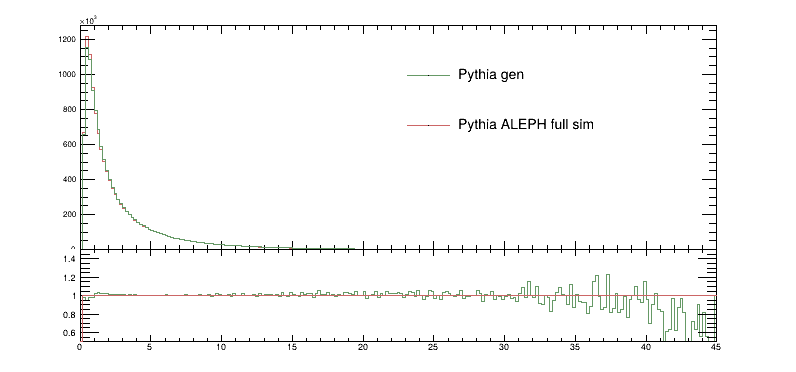

In [259]:
responsefname = 'response_matchonly_LEP1MC1994_recons_aftercut.root'

f = ROOT.TFile(responsefname, 'r')

h1 = f.Get('gen_match_pt')
h2 = f.Get('reco_match_pt')
#h1 = f.Get('gen_miss_pt')

rebin = 2
h1.Rebin(rebin)
h2.Rebin(rebin)
#ratio = h1.Clone('ratio')
#ratio2 = h2.Clone('ratio')
#total = h1.Clone('total')
#total.Add(h2)

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetLineWidth(1)
ROOT.gStyle.SetLegendBorderSize(0)
c0 = ROOT.TCanvas("tmp", "", 0, 0, 800, 400)

c0.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetTicks(1, 1)
pad2.SetTicks(1, 1)

pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25) 

pad1.Draw()
pad2.Draw()

pad1.cd()
pad1.SetLogy(0)


h2.Draw('')
h2.SetTitle('')
h2.SetLineColor(ROOT.kRed-6)
h2.SetLineWidth(1)
h2.GetYaxis().SetTickLength(0.02)
h2.GetXaxis().SetTickLength(0.04)
#h1.GetXaxis().SetTickLength(0.1)
h1.GetYaxis().SetNdivisions(505)


h1.SetLineColor(ROOT.kGreen-5)
h1.SetLineWidth(1)
h1.SetTitle('')
h1.Draw('samehist')

legend = ROOT.TLegend(0.5, 0.4, 0.8, 0.8)
legend.AddEntry(h1, "Pythia gen", 'alp')
legend.AddEntry(h2, "Pythia ALEPH full sim", 'alp')
#legend.AddEntry(mc_eec, "GEN 1d", 'alp')
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

ratio1 = h1.Clone('ratio')
ratio2 = h2.Clone('ratio2')

pad2.cd()

#total = h1.Clone('total')
#total.Add(h2)
ratio1.Divide(h2)
ratio1.SetMinimum(0.5)
ratio1.SetMaximum(1.5)
ratio1.GetYaxis().SetLabelSize(0.08)
ratio1.GetXaxis().SetLabelSize(0.08)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetTickLength(0.03)
ratio1.GetXaxis().SetTickLength(0.06)

ratio2.Divide(h2)

ratio1.Draw('')
ratio2.Draw('same')

c0.Draw()
c0.Show()

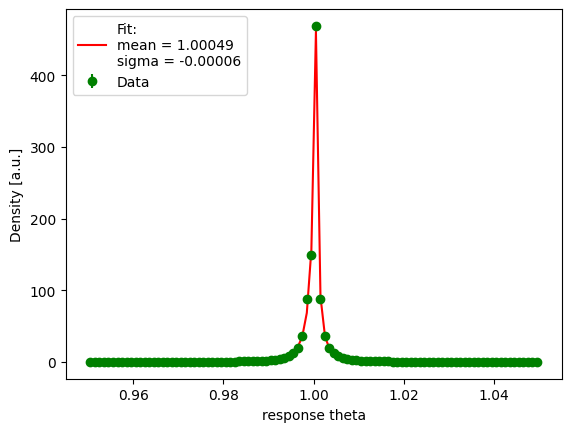

469.7874902789679 1.0004936906352702 -5.673108316000314e-05 0.13228181737361647 2.3311261948088715 0.07454162165539119 3.2054791932950333


In [221]:
resolutionfile = 'resolution_LEP1MC1994_pT.root'

# Open the ROOT file
file = uproot.open(resolutionfile)

# Access the TTree
tree = file["resolution"]

# Convert the TTree to a NumPy array
data = tree.arrays(["respT", "genT"], library="np")

# Access specific branches
response = data["respT"]

# Create a histogram (raw counts)
hist_counts, bin_edges = np.histogram(response, bins=100, range=(0.95, 1.05))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

# Calculate Poisson errors from the raw counts
errors_counts = np.sqrt(hist_counts)

# Normalize: for a normalized histogram (density), we need to divide by total counts and bin width.
norm_factor = np.sum(hist_counts)
hist = hist_counts / (norm_factor * bin_width)
errors = errors_counts / (norm_factor * bin_width)

# Define the fit range and create a mask to choose the subset for fitting.
fit_range = [0.95, 1.05]
fit_mask = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
x_fit = bin_centers[fit_mask]
y_fit = hist[fit_mask]
errors_fit = errors[fit_mask]

# Initial parameter guesses: N, mean, sigma, alphaL, nL, alphaR, nR
initial_params = [8000000, 1.0, 0.001, 1.5, .0, 1.5, .0]

# Fit the histogram in the selected x-range.
params, _ = curve_fit(double_sided_crystal_ball, x_fit, y_fit,
                      sigma=errors_fit, p0=initial_params)

# Prepare the fit line for plotting using a denser set of points.
x_fit_plt = np.linspace(fit_range[0], fit_range[1], 100)
y_fit_plt = double_sided_crystal_ball(x_fit_plt, *params)

# Plot the normalized histogram with Poisson error bars and the fit.
plt.errorbar(bin_centers, hist, yerr=errors, fmt='o', label='Data', color='g')
plt.plot(x_fit_plt, y_fit_plt, 'r-', label=f'Fit:\nmean = {params[1]:.5f}\nsigma = {params[2]:.5f}')
plt.xlabel('response theta')
plt.ylabel('Density [a.u.]')
plt.legend(loc='upper left')
plt.show()

print(*params)

/var/folders/r_/1bspz6w925z6z__xg3db1bcr0000gp/T/ipykernel_15798/403585777.py:34: RuntimeWarning: invalid value encountered in scalar power
  A_l = (n_l / np.abs(alpha_l))**n_l * np.exp(-0.5 * alpha_l**2)
/var/folders/r_/1bspz6w925z6z__xg3db1bcr0000gp/T/ipykernel_15798/403585777.py:40: RuntimeWarning: invalid value encountered in scalar power
  A_r = (n_r / np.abs(alpha_r))**n_r * np.exp(-0.5 * alpha_r**2)


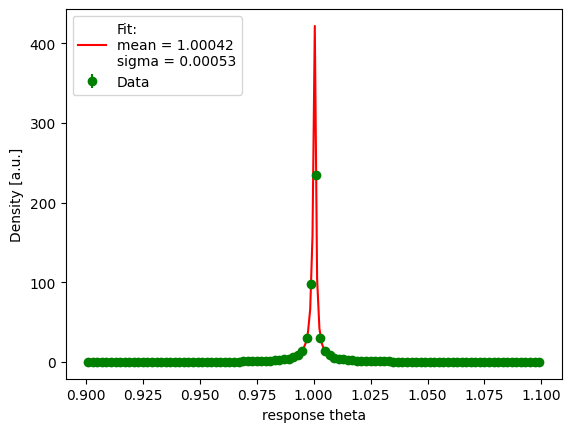

427.0688179936158 1.0004238929562863 0.000525468876141816 0.8281928946054009 1.839065139784283 1.0837800338223944 1.5659047239951855


In [218]:
# Open the ROOT file
file = uproot.open(resolutionfile)

# Access the TTree
tree = file["resolution"]

# Convert the TTree to a NumPy array
data = tree.arrays(["respF", "genF"], library="np")

# Access specific branches
response = data["respF"]

# Create a histogram (raw counts)
hist_counts, bin_edges = np.histogram(response, bins=100, range=(0.9, 1.1))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

# Calculate Poisson errors from the raw counts
errors_counts = np.sqrt(hist_counts)

# Normalize: for a normalized histogram (density), we need to divide by total counts and bin width.
norm_factor = np.sum(hist_counts)
hist = hist_counts / (norm_factor * bin_width)
errors = errors_counts / (norm_factor * bin_width)

# Define the fit range and create a mask to choose the subset for fitting.
fit_range = [0.95, 1.05]
fit_mask = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
x_fit = bin_centers[fit_mask]
y_fit = hist[fit_mask]
errors_fit = errors[fit_mask]

# Initial parameter guesses: N, mean, sigma, alphaL, nL, alphaR, nR
initial_params = [8000000, 1.0, 0.001, 1.5, .0, 1.5, .0]

# Fit the histogram in the selected x-range.
params, _ = curve_fit(double_sided_crystal_ball, x_fit, y_fit,
                      sigma=errors_fit, p0=initial_params)

# Prepare the fit line for plotting using a denser set of points.
x_fit_plt = np.linspace(fit_range[0], fit_range[1], 100)
y_fit_plt = double_sided_crystal_ball(x_fit_plt, *params)

# Plot the normalized histogram with Poisson error bars and the fit.
plt.errorbar(bin_centers, hist, yerr=errors, fmt='o', label='Data', color='g')
plt.plot(x_fit_plt, y_fit_plt, 'r-', label=f'Fit:\nmean = {params[1]:.5f}\nsigma = {params[2]:.5f}')
plt.xlabel('response theta')
plt.ylabel('Density [a.u.]')
plt.legend(loc='upper left')
plt.show()

print(*params)

/var/folders/r_/1bspz6w925z6z__xg3db1bcr0000gp/T/ipykernel_15798/403585777.py:40: RuntimeWarning: overflow encountered in scalar power
  A_r = (n_r / np.abs(alpha_r))**n_r * np.exp(-0.5 * alpha_r**2)
/var/folders/r_/1bspz6w925z6z__xg3db1bcr0000gp/T/ipykernel_15798/403585777.py:42: RuntimeWarning: invalid value encountered in multiply
  result[mask_right] = N * A_r * (B_r + t[mask_right])**(-n_r)
/var/folders/r_/1bspz6w925z6z__xg3db1bcr0000gp/T/ipykernel_15798/403585777.py:42: RuntimeWarning: overflow encountered in scalar multiply
  result[mask_right] = N * A_r * (B_r + t[mask_right])**(-n_r)
/var/folders/r_/1bspz6w925z6z__xg3db1bcr0000gp/T/ipykernel_15798/403585777.py:34: RuntimeWarning: overflow encountered in scalar power
  A_l = (n_l / np.abs(alpha_l))**n_l * np.exp(-0.5 * alpha_l**2)
/var/folders/r_/1bspz6w925z6z__xg3db1bcr0000gp/T/ipykernel_15798/403585777.py:36: RuntimeWarning: invalid value encountered in multiply
  result[mask_left] = N * A_l * (B_l - t[mask_left])**(-n_l)
/va

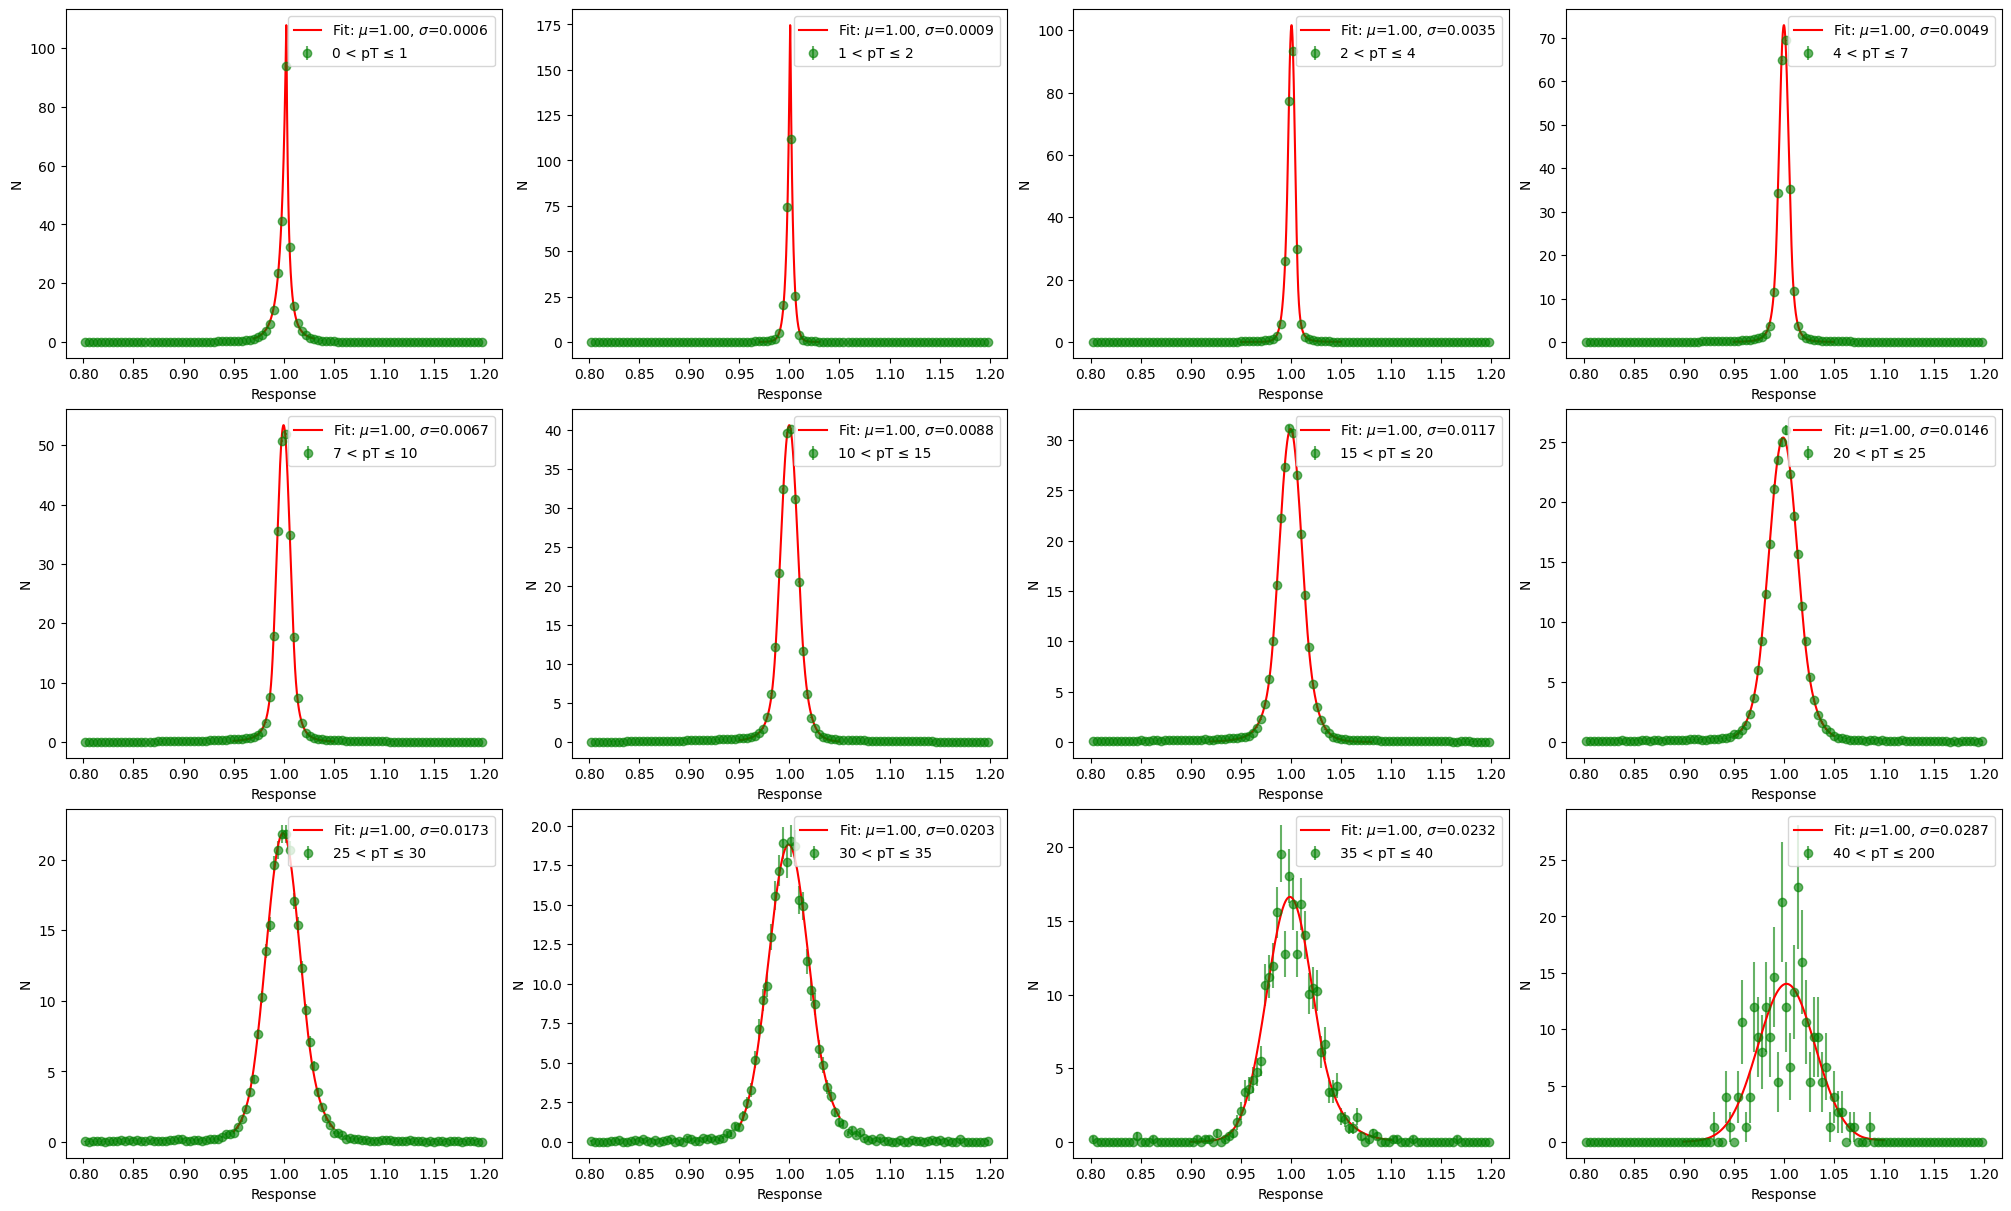

Results saved to fit_results_cb2.json


In [207]:
# Open the ROOT file
file = uproot.open(resolutionfile)

# Access the TTree
tree = file["resolution"]

# Convert the TTree to a NumPy array
data = tree.arrays(["respE", "genE"], library="np")

# Access specific branches
response = data["respE"]
generator = data["genE"]

# Define the overall plot range for the response histogram
plot_range = (0.8, 1.2)

# Define the cut boundaries
cuts = [0, 1, 2, 4, 7, 10, 15, 20, 25, 30, 35, 40, 200]
# Create intervals (each interval represented as [lower, upper])
cut_intervals = [[cuts[i], cuts[i+1]] for i in range(len(cuts) - 1)]

fit_ranges = [[0.97, 1.03], [0.97, 1.03],[0.95, 1.05], [0.95, 1.05], [0.95, 1.05], [0.95, 1.05], 
              [0.92, 1.08], [0.95, 1.05], [0.95, 1.05], [0.95, 1.05], [0.9, 1.1], 
              [0.9, 1.1], [0.8, 1.2]]

init_sigma = [0.0006, 0.0012, 0.0024, 0.005, 0.005, 0.005, 0.01, 0.01, 0.01, 0.02, 0.02, 0.03]

results = []

ncols = 4
nrows = math.ceil(len(cut_intervals) / ncols)

# Create a figure and subplots arranged in nrows x ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True)
axs = axs.flatten()

for i, (interval, fit_range) in enumerate(zip(cut_intervals, fit_ranges)):
    ax = axs[i]
    
    # Select events where generator values fall inside the interval: (lower, upper]
    mask = (generator > interval[0]) & (generator <= interval[1])
    response_cut = response[mask]

    # Create a histogram for response_cut using the overall plot_range.
    hist, bins = np.histogram(response_cut, bins=100, range=plot_range, density=False)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Calculate Poisson errors on histogram counts
    errors = np.sqrt(hist)
    
    # Normalize histogram (and errors) to density using bin width and total counts
    bin_width = bins[1] - bins[0]
    norm_factor = bin_width * np.sum(hist)
    if norm_factor != 0:
        hist_density = hist / norm_factor
        errors_density = errors / norm_factor
    else:
        hist_density = hist
        errors_density = errors

    # Plot the histogram with error bars
    ax.errorbar(bin_centers, hist_density, yerr=errors_density, fmt='o', 
                color='g', alpha=0.6, label=f'{interval[0]} < pT ≤ {interval[1]}')
    
    # Use only histogram bins within the specified fit range for the fit.
    fit_mask = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
    x_fit = bin_centers[fit_mask]
    y_fit = hist_density[fit_mask]
    
    # Initial parameter guess for double-sided Crystal Ball:
    # [N, mu, sigma, alpha_l, n_l, alpha_r, n_r]
    init_N = max(y_fit) * 10 if len(y_fit) and max(y_fit) > 0 else 900
    initial_guess = [init_N, 1.0, init_sigma[i], 1.0, 2, 1.0, 2]

    # Fit the Gaussian to filtered_data if available and plot the fit curve
    if len(y_fit) > 0:
        #mean, std_dev = norm.fit(y_fit)
        popt, pcov = curve_fit(double_sided_crystal_ball, x_fit, y_fit, p0=initial_guess)#, bounds=(lower_bounds, upper_bounds))
        x = np.linspace(fit_range[0], fit_range[1], 1000)
        #y = norm.pdf(x, mean, std_dev)
        mean = popt[1]
        std_dev = popt[2]
        y = double_sided_crystal_ball(x, *popt)
        ax.plot(x, y, 'r-', label=r'Fit: $\mu$=%.2f, $\sigma$=%.4f' % (mean, std_dev))
        mean = float(mean)
        std_dev = float(std_dev)
    else:
        ax.text(0.92, 0.9, "No data", transform=ax.transAxes)

    #print(interval, popt)
    #print(pcov)

    results.append({
        "cut_interval": interval,
        "params": popt.tolist()
    })

    # Set subplot labels and title
    ax.set_xlabel('Response')
    ax.set_ylabel('N')
    ax.legend(loc='upper right')

# Turn off any unused subplots
for j in range(len(cut_intervals), len(axs)):
    fig.delaxes(axs[j])

#plt.suptitle('Gaussian Fit with Varying Generator Cuts and Dependent Fit Ranges', fontsize=16)
plt.show()

# Save the results to a JSON file in the specified format.
with open("fit_results_cb2.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

print("Results saved to fit_results_cb2.json")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: tmp


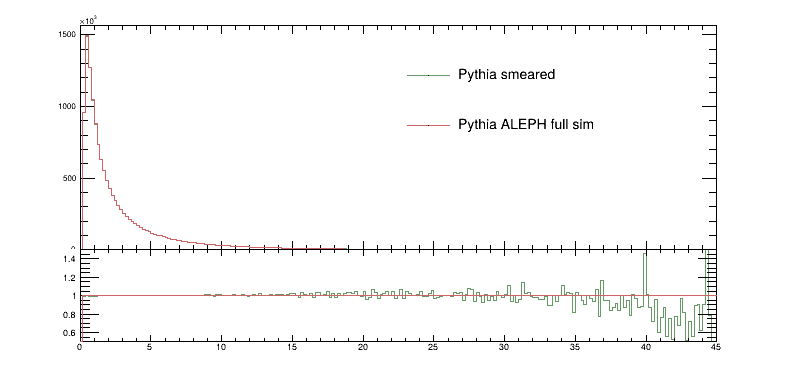

In [260]:
smrfname = 'response_smeared_matchonly_LEP1MC1994_recons_aftercut.root'
smrf = ROOT.TFile(smrfname, 'r')

recofname = 'response_matchonly_LEP1MC1994_recons_aftercut.root'
recof = ROOT.TFile(recofname, 'r')

#h1 = f.Get('reco_match_pt')
h1 = smrf.Get('smr_match_pt')
h2 = recof.Get('reco_match_pt')
h1.SetTitle('')

rebin = 2

h1.Rebin(10*rebin)
h2.Rebin(rebin)

#eff1 = h1.Clone("eff1")
eff1 = smrf.Get('gen_match_pt')
eff1.Rebin(10*rebin)
#eff2 = h2.Clone("eff2")
eff2 = recof.Get('gen_match_pt')
eff2.Rebin(rebin)
eff1.Divide(eff2)
h2.Multiply(eff1)

#h1.Scale(1./h1.Integral())
#h2.Scale(1./h2.Integral())

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetLineWidth(1)
ROOT.gStyle.SetLegendBorderSize(0)
c0 = ROOT.TCanvas("tmp", "", 0, 0, 800, 400)
c0.SetLogx()

c0.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetTicks(1, 1)
pad2.SetTicks(1, 1)

pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25) 

pad1.Draw()
pad2.Draw()

pad1.cd()
pad1.SetLogy(0)


h1.Draw('')
h1.SetLineColor(ROOT.kGreen-5)
h1.SetLineWidth(1)
h1.GetYaxis().SetTickLength(0.02)
h1.GetXaxis().SetTickLength(0.04)
#h1.GetXaxis().SetTickLength(0.1)
h1.GetYaxis().SetNdivisions(505)

h2.SetLineColor(ROOT.kRed-6)
h2.SetLineWidth(1)
h2.Draw('samehist')

legend = ROOT.TLegend(0.5, 0.4, 0.8, 0.8)
legend.AddEntry(h1, "Pythia smeared", 'alp')
legend.AddEntry(h2, "Pythia ALEPH full sim", 'alp')
#legend.AddEntry(mc_eec, "GEN 1d", 'alp')
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

ratio1 = h1.Clone('ratio')
ratio2 = h2.Clone('ratio2')

pad2.cd()

#total = h1.Clone('total')
#total.Add(h2)
ratio1.Divide(h2)
ratio1.SetMinimum(0.5)
ratio1.SetMaximum(1.5)
ratio1.GetYaxis().SetLabelSize(0.08)
ratio1.GetXaxis().SetLabelSize(0.08)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetTickLength(0.03)
ratio1.GetXaxis().SetTickLength(0.06)

ratio2.Divide(h2)

ratio1.Draw('')
ratio2.Draw('same')

c0.Draw()
c0.Show()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: tmp
Info in <TCanvas::Print>: png file EEC_smr_comp.png has been created


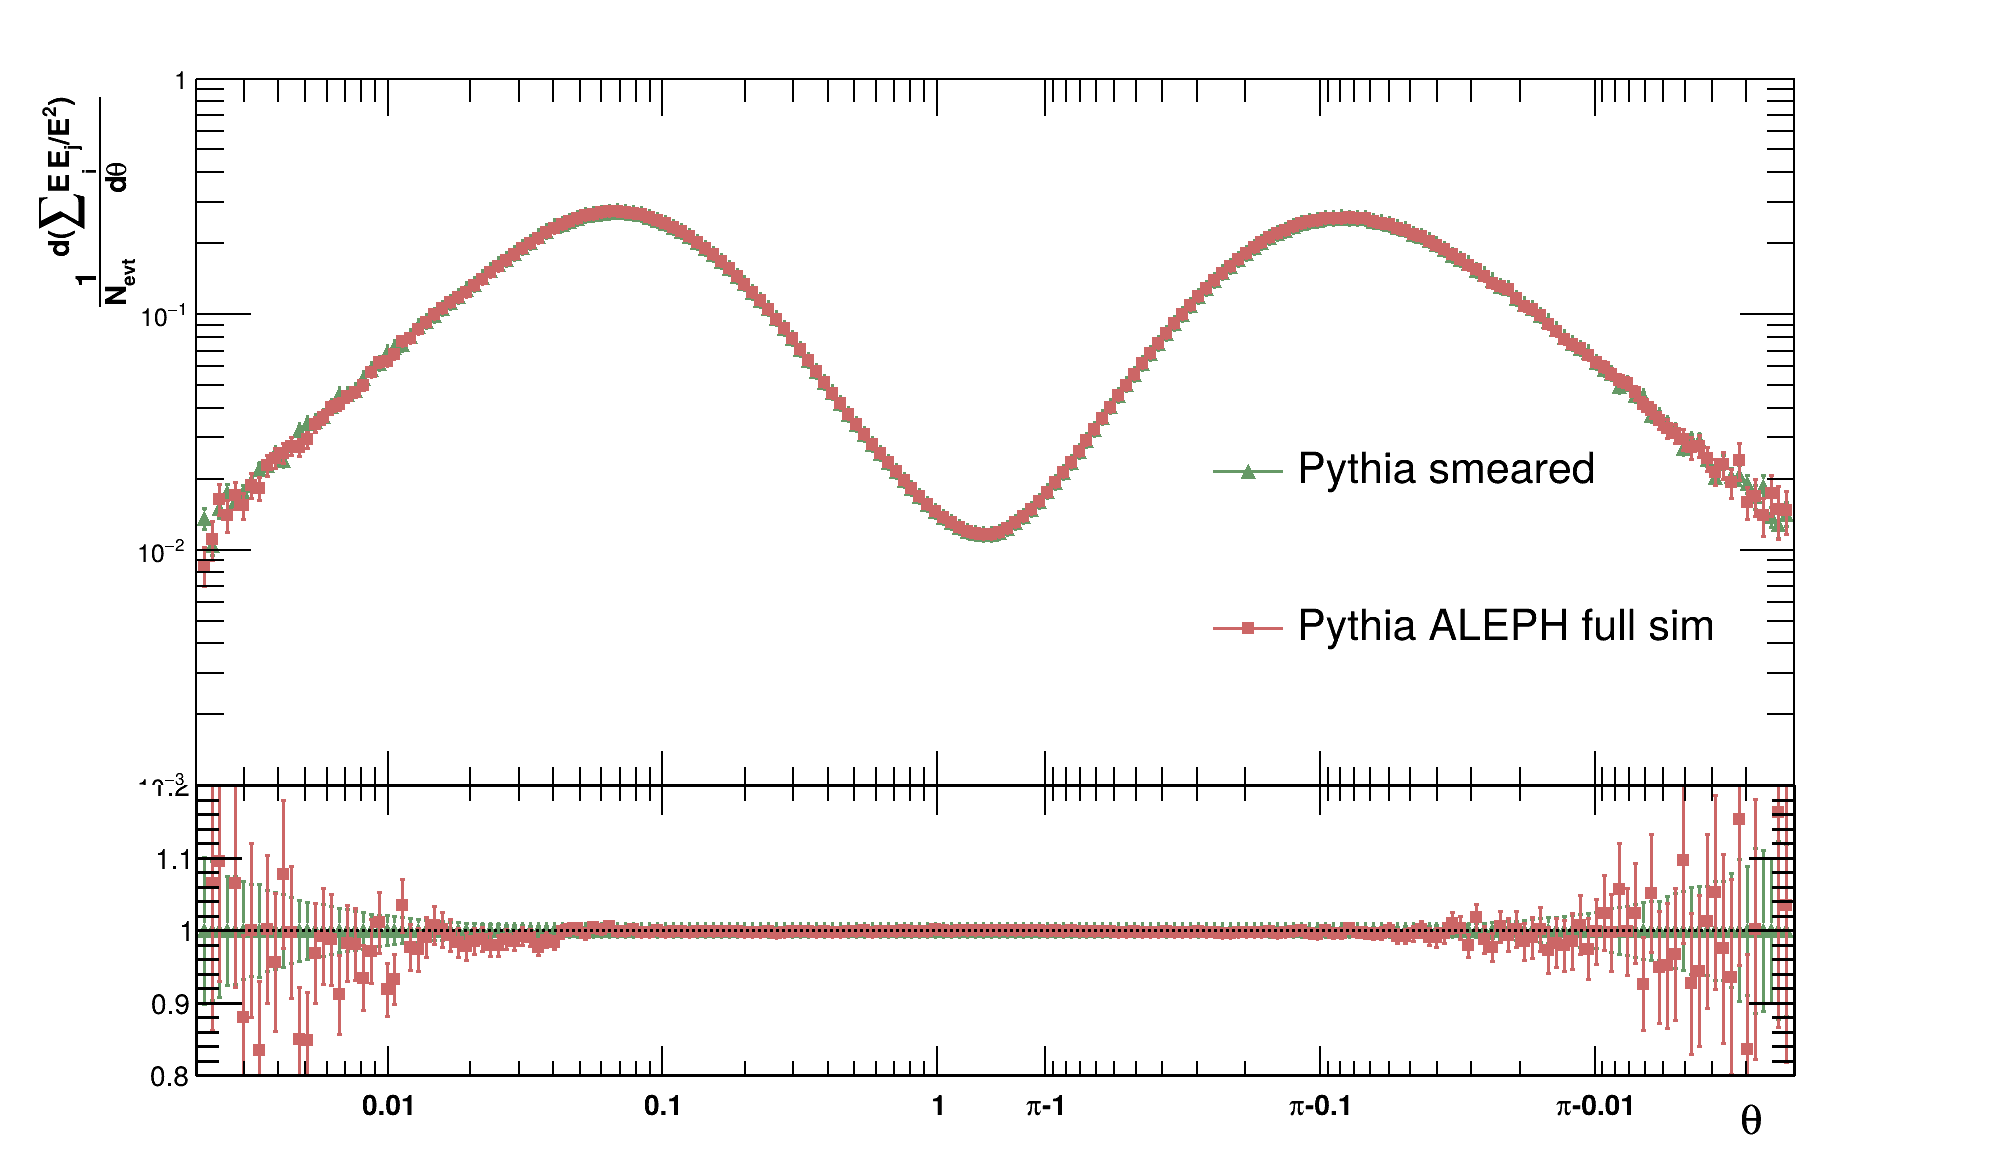

In [252]:
xlow = np.log10(0.002)
xhigh = np.log10(np.pi/2)
nbins = 100

width = (xhigh-xlow)/nbins

bins=[]
for i in range(nbins+1):
    val = pow(10, xlow + i * width)
    bins += [val]

newbins = [np.pi- b for b in bins]
newbins = newbins[::-1]
del newbins[0]

bin_edge = bins+newbins

smrfname = 'response_smeared_matchonly_LEP1MC1994_recons_aftercut.root'
smrf = ROOT.TFile(smrfname, 'r')

recofname = 'response_matchonly_LEP1MC1994_recons_aftercut.root'
recof = ROOT.TFile(recofname, 'r')

eijbins2 = [0.0, 0.0001, 0.0002, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002, 0.00225, 0.0025, 0.00275, 0.003, 0.0035, 0.004, 0.005, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.15, 0.20, 0.3, 1]
normalization1 = smrf.Get('counter').GetBinContent(2)
normalization2 = recof.Get('counter').GetBinContent(2)

#miss = recof.Get('miss_r')

#print(normalization1, normalization2)

hdata1 = smrf.Get('smr1d_eec')
hdata1.Scale(0.)
hdata1.SetDirectory(0)
unfold1 = []
h2d = smrf.Get('smr2d_eij_r_bin2')
for i in range(len(eijbins2)-1):
    unfold1d = Proj2D_X(h2d, eijbins2[i], eijbins2[i+1], f"SMR_Eij_Bin{i}")
    unfold1d.SetDirectory(0)
    #print(unfold1d.Integral())
    unfold1+=[unfold1d]
    unfold1d.Scale((eijbins2[i]+eijbins2[i+1])/2.)
    hdata1.Add(unfold1d)
#hdata1.Add(miss, -1)
hdata1=devideBinWidth(hdata1)
hdata1.Scale(1./normalization1)

eff1 = smrf.Get('gen1d_eec')
eff1.Scale(0.)
eff1.SetDirectory(0)
unfold3 = []
h2d = smrf.Get('gen2d_eij_r_bin2')
for i in range(len(eijbins2)-1):
    unfold1d = Proj2D_X(h2d, eijbins2[i], eijbins2[i+1], f"GEN_Eij_Bin{i}")
    unfold1d.SetDirectory(0)
    unfold3+=[unfold1d]
    unfold1d.Scale((eijbins2[i]+eijbins2[i+1])/2.)
    eff1.Add(unfold1d)
#hdata1.Add(miss, -1)
#eff1=devideBinWidth(eff1)
#eff1.Scale(1./normalization1)

#print('---------')

hdata2 = recof.Get('reco1d_eec')
hdata2.Scale(0.)
hdata2.SetDirectory(0)
unfold2 = []
h2d = recof.Get('reco2d_eij_r_bin2_matchonly')
for i in range(len(eijbins2)-1):
    unfold1d = Proj2D_X(h2d, eijbins2[i], eijbins2[i+1], f"RECO_Eij_Bin{i}")
    unfold1d.SetDirectory(0)
    unfold1+=[unfold1d]
    unfold1d.Scale((eijbins2[i]+eijbins2[i+1])/2.)
    hdata2.Add(unfold1d)
hdata2=devideBinWidth(hdata2)
hdata2.Scale(1./normalization2)

eff2 = recof.Get('gen1d_eec')
eff2.Scale(0.)
eff2.SetDirectory(0)
unfold4 = []
h2d = recof.Get('gen2d_eij_r_bin2_matchonly')
for i in range(len(eijbins2)-1):
    unfold1d = Proj2D_X(h2d, eijbins2[i], eijbins2[i+1], f"GEN2_Eij_Bin{i}")
    unfold1d.SetDirectory(0)
    unfold4+=[unfold1d]
    unfold1d.Scale((eijbins2[i]+eijbins2[i+1])/2.)
    eff2.Add(unfold1d)
#hdata1.Add(miss, -1)
#eff2=devideBinWidth(eff2)
#eff2.Scale(1./normalization2)

eff1.Divide(eff2)
hdata2.Multiply(eff1)

data1_eec = ROOT.TGraphErrors()
data2_eec = ROOT.TGraphErrors()
#mc_eec = ROOT.TGraphErrors()
ratio1 = ROOT.TGraphErrors()
ratio2 = ROOT.TGraphErrors()

bins = []
eecs = []
errs = []
for b in range(hdata1.GetNbinsX()):
    data1_eec.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1))
    data1_eec.SetPointError(b, 0, hdata1.GetBinError(b+1))
    data2_eec.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1))
    data2_eec.SetPointError(b, 0, hdata2.GetBinError(b+1))
    #mc_eec.SetPoint(b, b+0.5, hmc.GetBinContent(b+1))
    #mc_eec.SetPointError(b, 0, hmc.GetBinError(b+1))
    #den = hmc.GetBinContent(b+1) 
    den = hdata1.GetBinContent(b+1)
    bins+=[hdata1.GetBinCenter(b+1)]
    eecs+=[hdata2.GetBinContent(b+1)]
    errs+=[hdata2.GetBinError(b+1)]
    ratio1.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1)/den)
    ratio1.SetPointError(b, 0, hdata1.GetBinError(b+1)/den)
    ratio2.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1)/den)
    ratio2.SetPointError(b, 0, hdata2.GetBinError(b+1)/den)

labels=np.array([0.01, 0.1, 1, np.pi-1, np.pi-0.1, np.pi-0.01])
t_labels=['0.01', '0.1', '1', '#pi-1', '#pi-0.1', '#pi-0.01']

lower_indices = np.searchsorted(bins, labels, side='right') - 1
lower_indices = np.clip(lower_indices, 0, len(bins) - 2)  # Ensure we don't go out of bounds

bins = np.array(bins)

# Compute fractional indices
x0 = bins[lower_indices]
x1 = bins[lower_indices + 1]
fractional_part = (labels - x0) / (x1 - x0)
indices = lower_indices + fractional_part  # Final fractional indices

increments = [0.001, 0.01, 0.1]
points_to_extrapolate = [
    increment + increment * i
    for increment in increments
    for i in range(10)
]

points_to_extrapolate=[]
for i in range(9):
    points_to_extrapolate+=[0.002+0.001*i]
for i in range(10):
    points_to_extrapolate+=[0.01+0.01*i]
for i in range(10):
    points_to_extrapolate+=[0.1+0.1*i]

lower_indices = np.searchsorted(bins, points_to_extrapolate, side='right') - 1
lower_indices = np.clip(lower_indices, 0, len(bins) - 2)  # Ensure we don't go out of bounds

# Compute fractional indices
x0 = bins[lower_indices]
x1 = bins[lower_indices + 1]
fractional_part = (points_to_extrapolate - x0) / (x1 - x0)
p_indices = lower_indices + fractional_part  # Final fractional indices

ROOT.gStyle.SetLineWidth(0)

xmin = 0.
xmax = 200.

ymin = 0.001
ymax = 1

rymin = 0.8
rymax = 1.2
rylen = rymax-rymin

ticks = []

ROOT.gStyle.SetOptStat(0)
c4 = ROOT.TCanvas("tmp", "", 0, 0, 2000, 1200)

c4.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetFrameLineWidth(0)
pad2.SetFrameLineWidth(0)

pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25) 

pad1.Draw()
pad2.Draw()

pad1.cd()
pad1.SetLogy()
data1_eec.Draw('ap')
data1_eec.SetMarkerSize(2)
data1_eec.SetMarkerStyle(22)
data1_eec.SetMarkerColor(ROOT.kGreen-5)
data1_eec.SetLineColor(ROOT.kGreen-5)
data1_eec.SetLineWidth(3)
data1_eec.GetXaxis().SetTickLength(0)
data1_eec.GetXaxis().SetLabelSize(0)
data1_eec.GetXaxis().SetRangeUser(xmin, xmax)
data1_eec.GetYaxis().SetRangeUser(ymin, ymax)

data2_eec.Draw('samep')
data2_eec.SetMarkerSize(1.5)
data2_eec.SetMarkerStyle(21)
data2_eec.SetMarkerColor(ROOT.kRed-6)
data2_eec.SetLineColor(ROOT.kRed-6)
data2_eec.SetLineWidth(3)

#mc_eec.Draw('samep')
#c_eec.SetMarkerSize(2)
#mc_eec.SetMarkerStyle(20)
#mc_eec.SetMarkerColor(ROOT.kGray+2)
#mc_eec.SetLineColor(ROOT.kGray+2)
#mc_eec.SetLineWidth(3)

data1_eec.Draw('samep')
data2_eec.Draw('samep')

f = ROOT.TF1("f", "log10(x)", ymin, ymax)
newaxis0 = ROOT.TGaxis(p_indices[0],ymin,p_indices[0],ymax,'f',505,"-G")
newaxis0.SetLabelSize(0)
newaxis0.SetLineWidth(2)
newaxis0.Draw()

newaxis1 = ROOT.TGaxis(xmax-p_indices[0],ymin,xmax-p_indices[0],ymax,'f',505,"+G")
newaxis1.SetLabelSize(0)
newaxis1.SetLineWidth(2)
newaxis1.Draw()

l0 = ROOT.TLine(xmin,ymax,xmax,ymax)
l0.SetLineWidth(2)
l0.Draw()

l1 = ROOT.TLine(xmin,ymin,xmax,ymin)
l1.SetLineWidth(2)
l1.Draw()

for i,l in enumerate(t_labels):
    tick = ROOT.TLine(indices[i], 0.7*ymax, indices[i], ymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for i,l in enumerate(t_labels):
    tick = ROOT.TLine(indices[i], ymin, indices[i], ymin+ymin*0.4)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmin+point, 0.8*ymax, xmin+point, ymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]
  
for point in p_indices:
    tick = ROOT.TLine(xmax-point, 0.8*ymax, xmax-point, ymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmin+point, ymin, xmin+point, ymin+ymin*0.2)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]
  
for point in p_indices:
    tick = ROOT.TLine(xmax-point, ymin, xmax-point, ymin+ymin*0.2)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.04) 
txt1.SetTextAlign(22) 
txt1.SetTextAngle(90)
txt1.DrawLatex(-14, 0.3*ymax, "#frac{1}{N_{evt}}#frac{d(#sumE_{i}E_{j}/E^{2})}{d#theta}")

legend = ROOT.TLegend(0.6, 0.1, 0.8, 0.5)
legend.AddEntry(data1_eec, "Pythia smeared", 'alp')
legend.AddEntry(data2_eec, "Pythia ALEPH full sim", 'alp')
#legend.AddEntry(mc_eec, "GEN 1d", 'alp')
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

pad2.cd()
ratio1.Draw('ap')
ratio1.SetLineWidth(2)
ratio1.GetXaxis().SetTickLength(0)
ratio1.GetXaxis().SetLabelSize(0)
ratio1.GetXaxis().SetRangeUser(xmin, xmax)
ratio1.SetMarkerSize(2)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(ROOT.kGreen-5)
ratio1.SetLineColor(ROOT.kGreen-5)
ratio1.SetLineWidth(3)

ratio1.GetYaxis().SetRangeUser(rymin, rymax)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetLabelSize(0.08)

ratio2.Draw('samep')
ratio2.SetMarkerSize(1.5)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(ROOT.kRed-6)
ratio2.SetLineColor(ROOT.kRed-6)
ratio2.SetLineWidth(3)

for i,l in enumerate(t_labels):
    latex = ROOT.TLatex()
    latex.SetTextSize(0.08) 
    latex.SetTextAlign(22) 
    latex.DrawLatex(indices[i], rymin-0.1*rylen, l)
    tick = ROOT.TLine(indices[i], rymin, indices[i], rymin+rylen*0.1)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for i,l in enumerate(t_labels):
    tick = ROOT.TLine(indices[i], rymax-rylen*0.1, indices[i], rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmin+point, rymin, xmin+point, rymin+rylen*0.05)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmax-point, rymin, xmax-point, rymin+rylen*0.05)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmin+point, rymax-rylen*0.05, xmin+point, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmax-point, rymax-rylen*0.05, xmax-point, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

newaxis2 = ROOT.TGaxis(p_indices[0], rymin, p_indices[0], rymax, rymin, rymax, 505, '-L')
newaxis2.SetLabelSize(0)
newaxis2.SetLineWidth(3)
newaxis2.Draw()

newaxis3 = ROOT.TGaxis(xmax-p_indices[0], rymin, xmax-p_indices[0], rymax, rymin, rymax, 505, '+L')
newaxis3.SetLabelSize(0)
newaxis3.SetLineWidth(3)
newaxis3.Draw()

l2 = ROOT.TLine(0, rymax, 200, rymax)
l2.SetLineWidth(3)
l2.Draw()

l3 = ROOT.TLine(0, rymin, 200, rymin)
l3.SetLineWidth(3)
l3.Draw()

l4 = ROOT.TLine(0,1,200,1)
l4.SetLineWidth(3)
l4.SetLineStyle(2)
l4.Draw()

txt2 = ROOT.TLatex()
txt2.SetTextSize(0.12) 
txt2.SetTextAlign(22) 
txt2.DrawLatex(195, rymin-0.15*rylen, "#theta")

c4.Draw()

c4.SaveAs('EEC_smr_comp.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: tmp
Info in <TCanvas::Print>: png file EEC_unfold_comp.png has been created


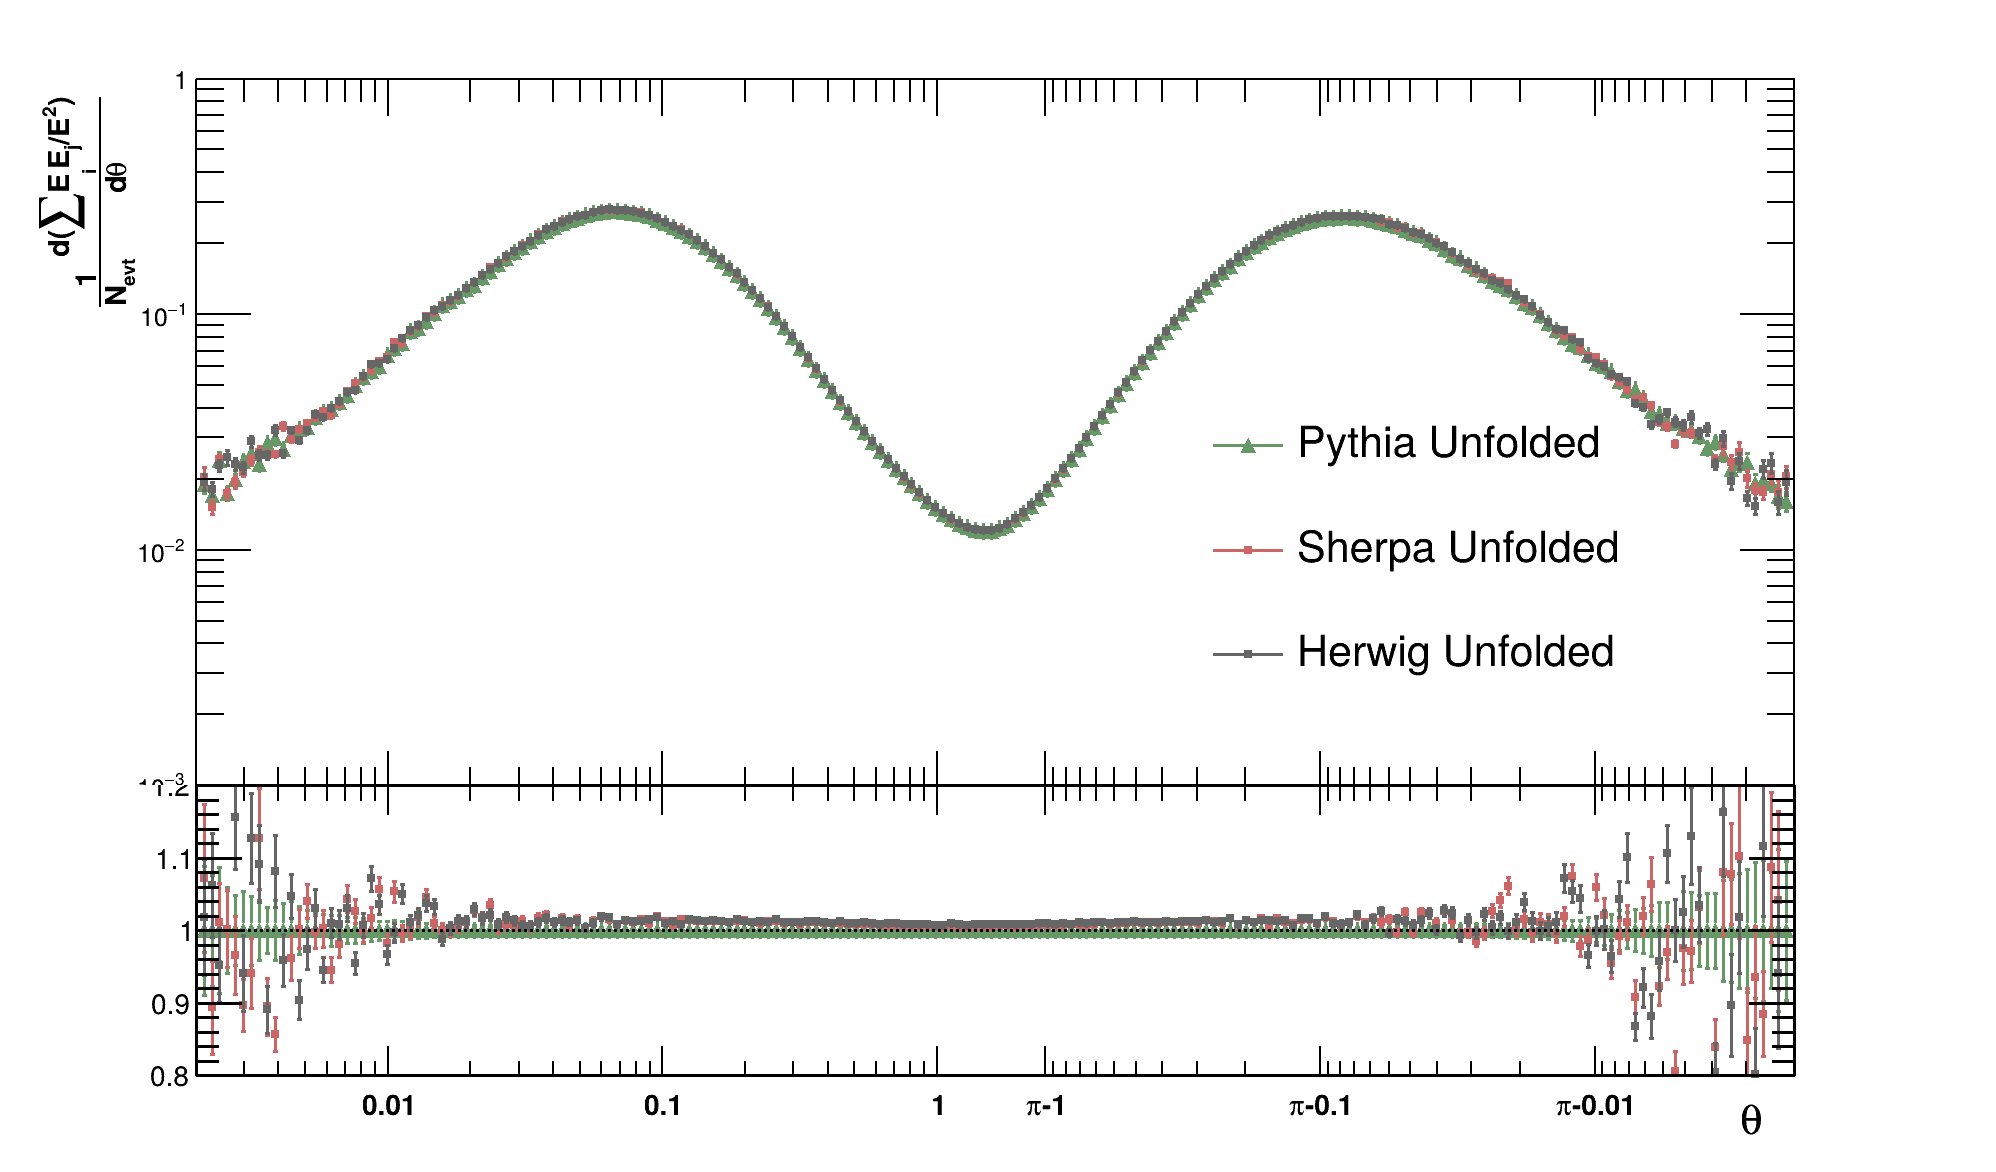

In [278]:
xlow = np.log10(0.002)
xhigh = np.log10(np.pi/2)
nbins = 100

width = (xhigh-xlow)/nbins

bins=[]
for i in range(nbins+1):
    val = pow(10, xlow + i * width)
    bins += [val]

newbins = [np.pi- b for b in bins]
newbins = newbins[::-1]
del newbins[0]

bin_edge = bins+newbins

def devideBinWidth(h):
    for b in range(h.GetNbinsX()):
        h.SetBinContent(b+1, h.GetBinContent(b+1)/h.GetBinWidth(b+1))
        h.SetBinError(b+1, h.GetBinError(b+1)/h.GetBinWidth(b+1))
    return h

def Proj2D_X(h,ymin,ymax,hname="XXX",Debug=False):

    # project 2D histogram into 1D along Y

    imin=h.GetYaxis().FindBin(ymin)
    imax=h.GetYaxis().FindBin(ymax)-1

    proj_x=h.ProjectionX(hname, imin, imax)
    ROOT.SetOwnership(proj_x, True)

    return proj_x

smrfname = 'smeared_response_LEP1MC1994.root'
smrf = ROOT.TFile(smrfname, 'r')

recofname = 'smeared_response_Sherpa.root'
recof = ROOT.TFile(recofname, 'r')

recofname2 = 'smeared_response_Herwig715.root'
recof2 = ROOT.TFile(recofname2, 'r')

eijbins2 = [0.0, 0.0001, 0.0002, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002, 0.00225, 0.0025, 0.00275, 0.003, 0.0035, 0.004, 0.005, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.15, 0.20, 0.3, 1]
normalization1 = smrf.Get('counter').GetBinContent(2)
normalization2 = recof.Get('counter').GetBinContent(2)
normalization3 = recof2.Get('counter').GetBinContent(2)
#print(normalization1, normalization2)

unf1name = 'unfolded_smeared_LEP1MC1994_bin2.root'
unf2name = 'unfolded_smeared_Sherpa_bin2.root'
unf3name = 'unfolded_smeared_Herwig715_bin2.root'
unf1 = ROOT.TFile(unf1name, 'r')
unf2 = ROOT.TFile(unf2name, 'r')
unf3 = ROOT.TFile(unf3name, 'r')

hdata1 = smrf.Get('smr1d_eec')
hdata1.Scale(0.)
hdata1.SetDirectory(0)
unfold1 = []
for i in range(len(eijbins2)-1):
    unfold1d = unf1.Get(f'UNFOLD_Eij_Bin{i}')
    unfold1d.SetDirectory(0)
    #print(unfold1d.Integral())
    unfold1+=[unfold1d]
    unfold1d.Scale((eijbins2[i]+eijbins2[i+1])/2.)
    hdata1.Add(unfold1d)
hdata1=devideBinWidth(hdata1)
hdata1.Scale(1./normalization1)

#print('---------')

hdata2 = unf2.Get('UNFOLD_Eij_Bin0')
hdata2.Scale(0.)
hdata2.SetDirectory(0)
unfold2 = []
h2d = unf2.Get('UNFOLD_Eij_Bin0')
for i in range(len(eijbins2)-1):
    unfold1d = unf2.Get(f'UNFOLD_Eij_Bin{i}')
    unfold1d.SetDirectory(0)
    #print(unfold1d.Integral())
    unfold1+=[unfold1d]
    unfold1d.Scale((eijbins2[i]+eijbins2[i+1])/2.)
    hdata2.Add(unfold1d)
hdata2=devideBinWidth(hdata2)
hdata2.Scale(1./normalization1)

hdata3 = unf3.Get('UNFOLD_Eij_Bin0')
hdata3.Scale(0.)
hdata3.SetDirectory(0)
unfold3 = []
h2d = unf3.Get('UNFOLD_Eij_Bin0')
for i in range(len(eijbins2)-1):
    unfold1d = unf3.Get(f'UNFOLD_Eij_Bin{i}')
    unfold1d.SetDirectory(0)
    #print(unfold1d.Integral())
    unfold3+=[unfold1d]
    unfold1d.Scale((eijbins2[i]+eijbins2[i+1])/2.)
    hdata3.Add(unfold1d)
hdata3=devideBinWidth(hdata3)
hdata3.Scale(1./normalization1)

data1_eec = ROOT.TGraphErrors()
data2_eec = ROOT.TGraphErrors()
data3_eec = ROOT.TGraphErrors()
#mc_eec = ROOT.TGraphErrors()
ratio1 = ROOT.TGraphErrors()
ratio2 = ROOT.TGraphErrors()
ratio3 = ROOT.TGraphErrors()

bins = []
eecs = []
errs = []
for b in range(hdata1.GetNbinsX()):
    data1_eec.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1))
    data1_eec.SetPointError(b, 0, hdata1.GetBinError(b+1))
    data2_eec.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1))
    data2_eec.SetPointError(b, 0, hdata2.GetBinError(b+1))
    data3_eec.SetPoint(b, b+0.5, hdata3.GetBinContent(b+1))
    data3_eec.SetPointError(b, 0, hdata3.GetBinError(b+1))
    #mc_eec.SetPoint(b, b+0.5, hmc.GetBinContent(b+1))
    #mc_eec.SetPointError(b, 0, hmc.GetBinError(b+1))
    #den = hmc.GetBinContent(b+1) 
    den = hdata1.GetBinContent(b+1)
    bins+=[hdata1.GetBinCenter(b+1)]
    #eecs+=[hdata2.GetBinContent(b+1)]
    #errs+=[hdata2.GetBinError(b+1)]
    ratio1.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1)/den)
    ratio1.SetPointError(b, 0, hdata1.GetBinError(b+1)/den)
    ratio2.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1)/den)
    ratio2.SetPointError(b, 0, hdata2.GetBinError(b+1)/den)
    ratio3.SetPoint(b, b+0.5, hdata3.GetBinContent(b+1)/den)
    ratio3.SetPointError(b, 0, hdata3.GetBinError(b+1)/den)

labels=np.array([0.01, 0.1, 1, np.pi-1, np.pi-0.1, np.pi-0.01])
t_labels=['0.01', '0.1', '1', '#pi-1', '#pi-0.1', '#pi-0.01']

lower_indices = np.searchsorted(bins, labels, side='right') - 1
lower_indices = np.clip(lower_indices, 0, len(bins) - 2)  # Ensure we don't go out of bounds

bins = np.array(bins)

# Compute fractional indices
x0 = bins[lower_indices]
x1 = bins[lower_indices + 1]
fractional_part = (labels - x0) / (x1 - x0)
indices = lower_indices + fractional_part  # Final fractional indices

increments = [0.001, 0.01, 0.1]
points_to_extrapolate = [
    increment + increment * i
    for increment in increments
    for i in range(10)
]

points_to_extrapolate=[]
for i in range(9):
    points_to_extrapolate+=[0.002+0.001*i]
for i in range(10):
    points_to_extrapolate+=[0.01+0.01*i]
for i in range(10):
    points_to_extrapolate+=[0.1+0.1*i]

lower_indices = np.searchsorted(bins, points_to_extrapolate, side='right') - 1
lower_indices = np.clip(lower_indices, 0, len(bins) - 2)  # Ensure we don't go out of bounds

# Compute fractional indices
x0 = bins[lower_indices]
x1 = bins[lower_indices + 1]
fractional_part = (points_to_extrapolate - x0) / (x1 - x0)
p_indices = lower_indices + fractional_part  # Final fractional indices

ROOT.gStyle.SetLineWidth(0)

xmin = 0.
xmax = 200.

ymin = 0.001
ymax = 1

rymin = 0.8
rymax = 1.2
rylen = rymax-rymin

ticks = []

ROOT.gStyle.SetOptStat(0)
c4 = ROOT.TCanvas("tmp", "", 0, 0, 2000, 1200)

c4.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetFrameLineWidth(0)
pad2.SetFrameLineWidth(0)

pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25) 

pad1.Draw()
pad2.Draw()

pad1.cd()
pad1.SetLogy()
data1_eec.Draw('ap')
data1_eec.SetMarkerSize(2)
data1_eec.SetMarkerStyle(22)
data1_eec.SetMarkerColor(ROOT.kGreen-5)
data1_eec.SetLineColor(ROOT.kGreen-5)
data1_eec.SetLineWidth(3)
data1_eec.GetXaxis().SetTickLength(0)
data1_eec.GetXaxis().SetLabelSize(0)
data1_eec.GetXaxis().SetRangeUser(xmin, xmax)
data1_eec.GetYaxis().SetRangeUser(ymin, ymax)

data2_eec.Draw('samep')
data2_eec.SetMarkerSize(1)
data2_eec.SetMarkerStyle(21)
data2_eec.SetMarkerColor(ROOT.kRed-6)
data2_eec.SetLineColor(ROOT.kRed-6)
data2_eec.SetLineWidth(3)

data3_eec.Draw('samep')
data3_eec.SetMarkerSize(1)
data3_eec.SetMarkerStyle(21)
data3_eec.SetMarkerColor(ROOT.kGray+2)
data3_eec.SetLineColor(ROOT.kGray+2)
data3_eec.SetLineWidth(3)

#mc_eec.Draw('samep')
#c_eec.SetMarkerSize(2)
#mc_eec.SetMarkerStyle(20)
#mc_eec.SetMarkerColor(ROOT.kGray+2)
#mc_eec.SetLineColor(ROOT.kGray+2)
#mc_eec.SetLineWidth(3)

data1_eec.Draw('samep')
data2_eec.Draw('samep')
data3_eec.Draw('samep')

f = ROOT.TF1("f", "log10(x)", ymin, ymax)
newaxis0 = ROOT.TGaxis(p_indices[0],ymin,p_indices[0],ymax,'f',505,"-G")
newaxis0.SetLabelSize(0)
newaxis0.SetLineWidth(2)
newaxis0.Draw()

newaxis1 = ROOT.TGaxis(xmax-p_indices[0],ymin,xmax-p_indices[0],ymax,'f',505,"+G")
newaxis1.SetLabelSize(0)
newaxis1.SetLineWidth(2)
newaxis1.Draw()

l0 = ROOT.TLine(xmin,ymax,xmax,ymax)
l0.SetLineWidth(2)
l0.Draw()

l1 = ROOT.TLine(xmin,ymin,xmax,ymin)
l1.SetLineWidth(2)
l1.Draw()

for i,l in enumerate(t_labels):
    tick = ROOT.TLine(indices[i], 0.7*ymax, indices[i], ymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for i,l in enumerate(t_labels):
    tick = ROOT.TLine(indices[i], ymin, indices[i], ymin+ymin*0.4)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmin+point, 0.8*ymax, xmin+point, ymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]
  
for point in p_indices:
    tick = ROOT.TLine(xmax-point, 0.8*ymax, xmax-point, ymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmin+point, ymin, xmin+point, ymin+ymin*0.2)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]
  
for point in p_indices:
    tick = ROOT.TLine(xmax-point, ymin, xmax-point, ymin+ymin*0.2)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.04) 
txt1.SetTextAlign(22) 
txt1.SetTextAngle(90)
txt1.DrawLatex(-14, 0.3*ymax, "#frac{1}{N_{evt}}#frac{d(#sumE_{i}E_{j}/E^{2})}{d#theta}")

legend = ROOT.TLegend(0.6, 0.1, 0.8, 0.5)
legend.AddEntry(data1_eec, "Pythia Unfolded", 'alp')
legend.AddEntry(data2_eec, "Sherpa Unfolded", 'alp')
legend.AddEntry(data3_eec, "Herwig Unfolded", 'alp')
#legend.AddEntry(mc_eec, "GEN 1d", 'alp')
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

pad2.cd()
ratio1.Draw('ap')
ratio1.SetLineWidth(2)
ratio1.GetXaxis().SetTickLength(0)
ratio1.GetXaxis().SetLabelSize(0)
ratio1.GetXaxis().SetRangeUser(xmin, xmax)
ratio1.SetMarkerSize(2)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(ROOT.kGreen-5)
ratio1.SetLineColor(ROOT.kGreen-5)
ratio1.SetLineWidth(3)

ratio1.GetYaxis().SetRangeUser(rymin, rymax)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetLabelSize(0.08)

ratio2.Draw('samep')
ratio2.SetMarkerSize(1)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(ROOT.kRed-6)
ratio2.SetLineColor(ROOT.kRed-6)
ratio2.SetLineWidth(3)

ratio3.Draw('samep')
ratio3.SetMarkerSize(1)
ratio3.SetMarkerStyle(21)
ratio3.SetMarkerColor(ROOT.kGray+2)
ratio3.SetLineColor(ROOT.kGray+2)
ratio3.SetLineWidth(3)

for i,l in enumerate(t_labels):
    latex = ROOT.TLatex()
    latex.SetTextSize(0.08) 
    latex.SetTextAlign(22) 
    latex.DrawLatex(indices[i], rymin-0.1*rylen, l)
    tick = ROOT.TLine(indices[i], rymin, indices[i], rymin+rylen*0.1)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for i,l in enumerate(t_labels):
    tick = ROOT.TLine(indices[i], rymax-rylen*0.1, indices[i], rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmin+point, rymin, xmin+point, rymin+rylen*0.05)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmax-point, rymin, xmax-point, rymin+rylen*0.05)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmin+point, rymax-rylen*0.05, xmin+point, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

for point in p_indices:
    tick = ROOT.TLine(xmax-point, rymax-rylen*0.05, xmax-point, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks+=[tick]

newaxis2 = ROOT.TGaxis(p_indices[0], rymin, p_indices[0], rymax, rymin, rymax, 505, '-L')
newaxis2.SetLabelSize(0)
newaxis2.SetLineWidth(3)
newaxis2.Draw()

newaxis3 = ROOT.TGaxis(xmax-p_indices[0], rymin, xmax-p_indices[0], rymax, rymin, rymax, 505, '+L')
newaxis3.SetLabelSize(0)
newaxis3.SetLineWidth(3)
newaxis3.Draw()

l2 = ROOT.TLine(0, rymax, 200, rymax)
l2.SetLineWidth(3)
l2.Draw()

l3 = ROOT.TLine(0, rymin, 200, rymin)
l3.SetLineWidth(3)
l3.Draw()

l4 = ROOT.TLine(0,1,200,1)
l4.SetLineWidth(3)
l4.SetLineStyle(2)
l4.Draw()

txt2 = ROOT.TLatex()
txt2.SetTextSize(0.12) 
txt2.SetTextAlign(22) 
txt2.DrawLatex(195, rymin-0.15*rylen, "#theta")

c4.Draw()

c4.SaveAs('EEC_unfold_comp.png')